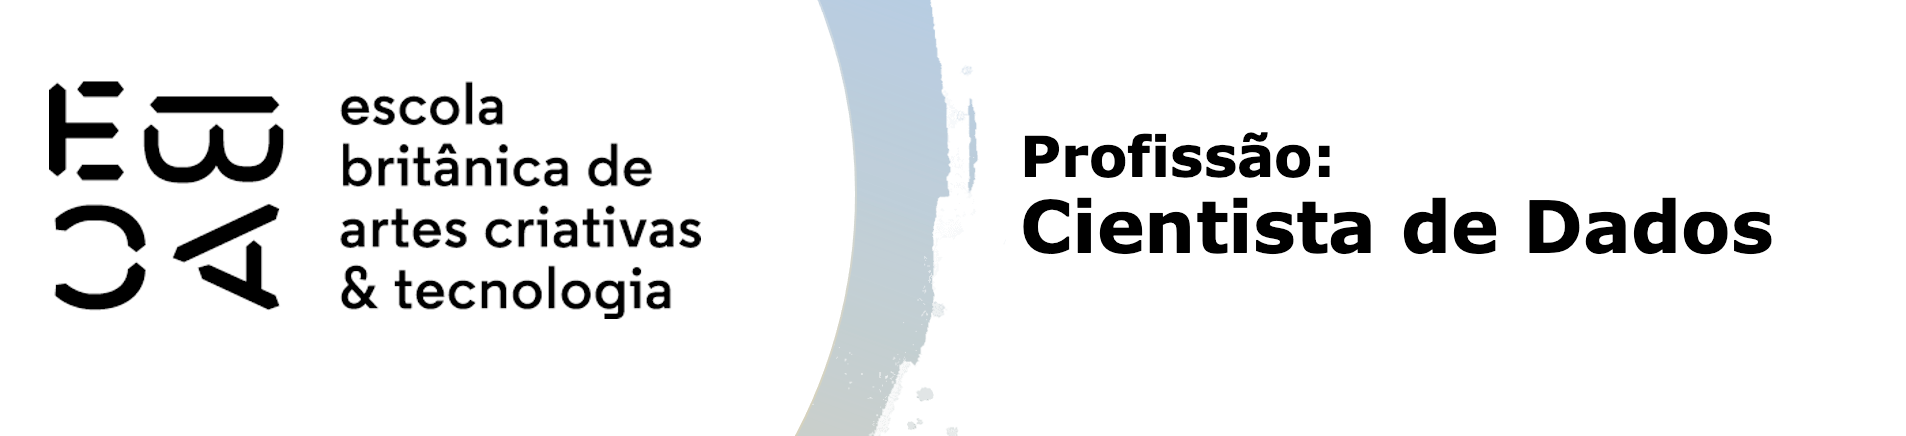

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(12, 5))

In [2]:
df = pd.read_pickle('base_nfp.pkl')

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [3]:
base = (
    df
    .assign(weekday = lambda x: x['Data Emissão'].dt.day_name())
    .assign(weekend = lambda x: (x['weekday'].isin(['Saturday', 'Sunday'])).astype('int'))
    .assign(workday = lambda x: (~x['weekday'].isin(['Saturday', 'Sunday'])).astype('int'))    
    .assign(day     = lambda x: x['Data Emissão'].dt.day)
    .assign(month   = lambda x: x['Data Emissão'].dt.month)
    .assign(quarter = lambda x: x['Data Emissão'].dt.quarter)
    .assign(cat5    = lambda x: pd.qcut(x=x['Valor NF'], q=5, duplicates='drop', precision=4))
    .assign(cat10   = lambda x: pd.qcut(x=x['Valor NF'], q=10, duplicates='drop', precision=4))
    .assign(cat20   = lambda x: pd.qcut(x=x['Valor NF'], q=20, duplicates='drop', precision=4))
    .assign(cat50   = lambda x: pd.qcut(x=x['Valor NF'], q=50, duplicates='drop', precision=4))
    .rename(columns={"Ano": "year", "Semestre": "semester"})
    .assign(ID      = lambda x: x.index)
)

In [4]:
base.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,year,semester,...,weekend,workday,day,month,quarter,cat5,cat10,cat20,cat50,ID
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,...,0,1,30,6,2,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(23.62, 25.14]",0
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,...,0,1,30,6,2,"(28.61, 55.0]","(38.88, 55.0]","(46.0275, 55.0]","(48.0, 50.72]",1
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,...,0,1,30,6,2,"(13.36, 28.61]","(20.29, 28.61]","(24.5, 28.61]","(26.9, 28.61]",2
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,...,0,1,30,6,2,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(107.04, 119.5]",3
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,...,0,1,30,6,2,"(55.0, 131.36]","(81.8, 131.36]","(101.48, 131.36]","(119.5, 131.36]",4


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [5]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rotulo_evento = tab.columns[0]
    rotulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rotulo_evento] / tab.loc['total', rotulo_evento]
    tab['pct_nao_evento'] = tab[rotulo_nao_evento] / tab.loc['total', rotulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento / tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento) * tab.woe
    
    return tab['iv_parcial'].sum()

In [6]:
def siddiqi_class(x):
    if np.isnan(x):
        return float("NAN")
    elif x < 0.02:
        return 'Inútil'
    elif (x >= 0.02) & (x < 0.1):
        return 'Fraco'
    elif (x >= 0.1) & (x < 0.3):
        return 'Médio'
    elif (x >= 0.3) & (x < 0.5):
        return 'Forte'
    else:
        return 'Suspeito'

In [7]:
metadados = pd.DataFrame({'dtype': base.dtypes})
metadados.drop(index=['CNPJ emit.', 'Emitente', 'No.', 'Data Emissão', 'Valor NF', 'ID'], inplace=True)
metadados.drop(index=['Data Registro', 'Situação do Crédito', 'Créditos', 'Retorno'], inplace=True)
metadados['papel'] = 'covariavel'
metadados['nunique'] = base.nunique()
metadados.loc['flag_credito', 'papel'] = 'resposta'

In [8]:
for var in metadados[metadados.papel=='covariavel'].index:
    metadados.loc[var, 'IV'] = IV(base[var], base.flag_credito)
metadados['classificacao'] = metadados['IV'].apply(siddiqi_class)

In [9]:
metadados

,dtype,papel,nunique,IV,classificacao
year,int64,covariavel,5,0.041651,Fraco
semester,int64,covariavel,2,0.001258,Inútil
flag_credito,int64,resposta,2,NaN,NaN
categoria,object,covariavel,9,0.408313,Forte
weekday,object,covariavel,7,0.006883,Inútil
weekend,int64,covariavel,2,0.004346,Inútil
workday,int64,covariavel,2,0.004346,Inútil
day,int64,covariavel,31,0.043719,Fraco
month,int64,covariavel,12,0.027833,Fraco
quarter,int64,covariavel,4,0.011507,Inútil


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

As variáveis que parecem apresentar maior poder de discriminação segundo o IV são **categoria** e **cat50**. Essa última é uma variável contínua categorizada em 50 quantis a partir do valor da nota fiscal.
    
<br>
    
 Sobre a relação entre o IV e as variáveis contínuas categorizadas, podemos verificar que o IV tende a aumentar conforme aumentamos a quantidade de quantis. 
    
</div>

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [10]:
def definie_coluna_periodo(db):
    db_base = db.reset_index()
    db_base['periodo'] = db_base['year'].astype('str') + " - " + db_base['quarter'].astype('str')
    db_base.drop(columns=['year', 'quarter'], inplace=True)
    return db_base

**A quantidade de notas registradas na base por período**

In [11]:
qtd_notas = base.groupby(['year', 'quarter']).agg(quantidade=('ID' , 'count'))
qtd_notas = definie_coluna_periodo(qtd_notas)
qtd_notas = qtd_notas.rolling(2, on='periodo').mean()

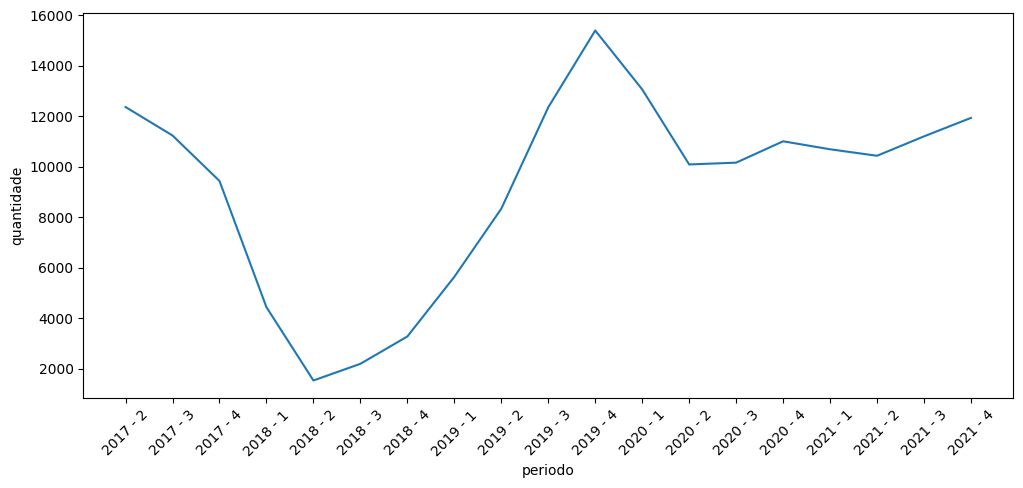

In [12]:
box = sns.lineplot(qtd_notas, x='periodo', y='quantidade')
box.tick_params(axis='x', labelrotation=45)

**A quantidade de notas por categoria e por período**

In [13]:
qtd_cats = definie_coluna_periodo(
    base.query('categoria != "não definido"')
    .groupby(['year', 'quarter', 'categoria'])
    .agg(quantidade=('ID' , 'count'))
    .rolling(2)
    .mean()
)

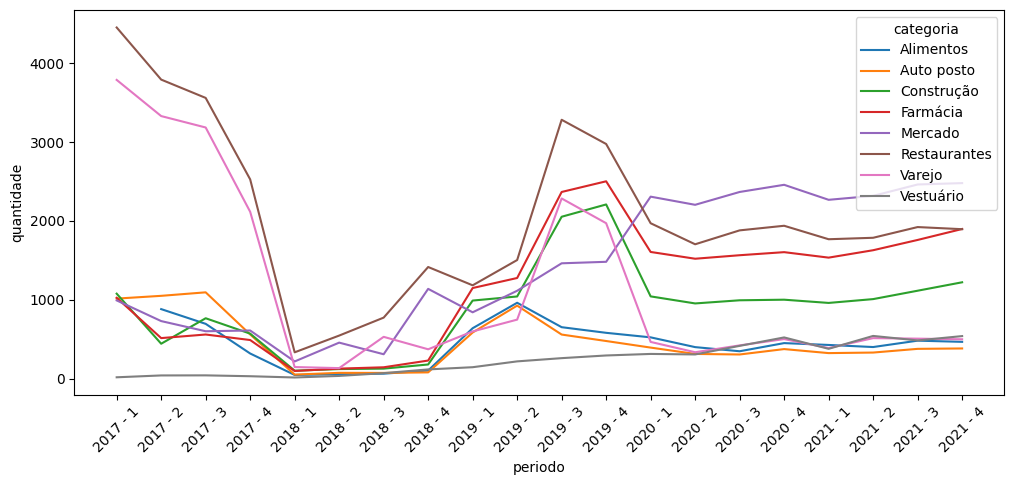

In [14]:
boxc = sns.lineplot(qtd_cats, x='periodo', y='quantidade', hue='categoria')
boxc.tick_params(axis='x', labelrotation=45)

**A proporção de notas com crédito por categoria por período**

In [15]:
df_cat = (
    base.query('categoria != "não definido"')
    .groupby(['year', 'quarter', 'categoria'])
    .agg({
        'flag_credito':[
            ('total', 'count'),
            ('nao_credito', lambda x: x.value_counts()[0]),
        ]
    })
    .assign(credito = lambda x: x['flag_credito']['total'] - x['flag_credito']['nao_credito'])
    .assign(diferenca = lambda x: x['credito'] - x['flag_credito']['nao_credito'])
    .assign(proporcao = lambda x: np.round((x['diferenca'] / x['flag_credito']['total']) * 100, 1))
    .reset_index()
)
df_cat.columns = [x[1][1] if len(x[1][1]) > 0 else x[1][0] for x in enumerate(df_cat.columns)]
df_cat = definie_coluna_periodo(df_cat)
df_cat.drop(columns=['index'], inplace=True)

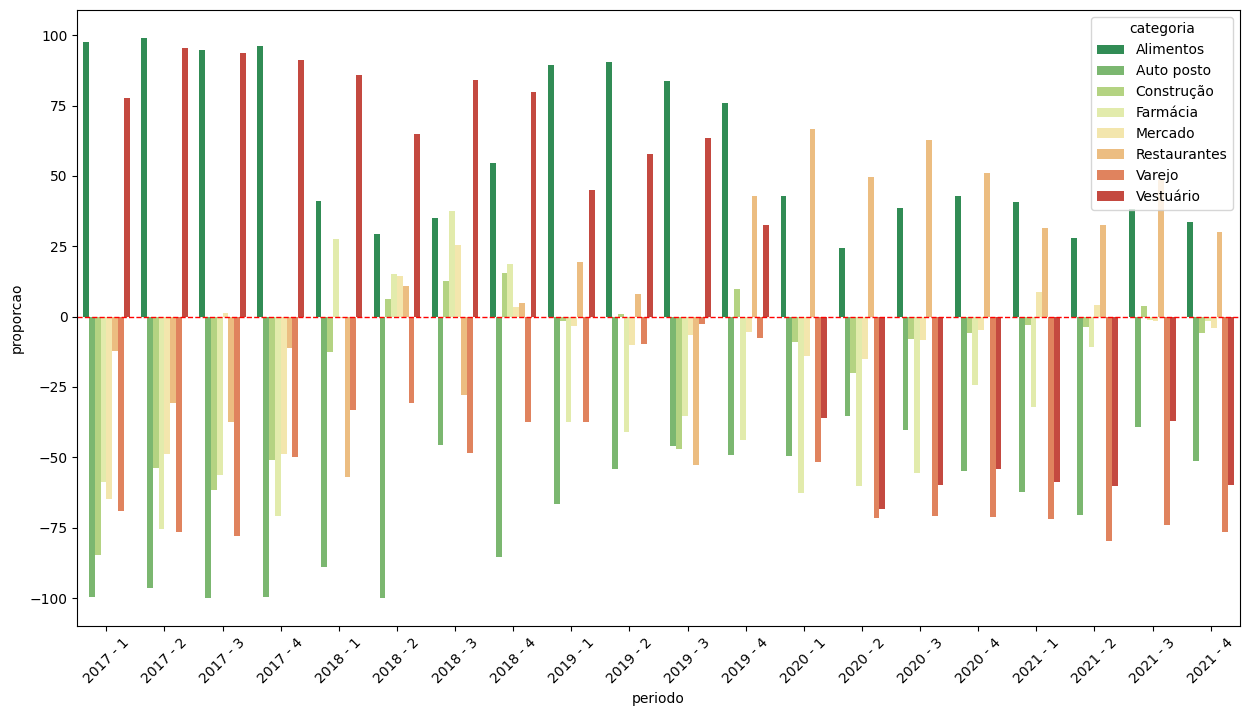

In [16]:
plt.rc("figure", figsize=(15, 8))
boxcp = sns.barplot(df_cat, x='periodo', y='proporcao', hue='categoria', errorbar=None, palette='RdYlGn_r');
boxcp.axhline(y=0, color="red", linestyle='--', linewidth=1);
boxcp.tick_params(axis='x', labelrotation=45)

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [17]:
df_odds = df_cat.groupby('periodo').agg(tot_credito=('credito', 'sum'), tot_nao_credito=('nao_credito', 'sum')).reset_index()
df_cat = pd.merge(df_cat, df_odds, on='periodo')

In [18]:
df_cat['pct_evento'] = df_cat['credito'] / df_cat['tot_credito']
df_cat['pct_nao_evento'] = df_cat['nao_credito'] / df_cat['tot_nao_credito']

df_cat['odds'] = df_cat['credito'] / df_cat['nao_credito']
df_cat['woe'] = np.log(0.0001 + (df_cat['odds'] / (df_cat['tot_credito'] / df_cat['tot_nao_credito'])))
df_cat['iv'] = (df_cat['pct_evento'] - df_cat['pct_nao_evento']) * df_cat['woe']

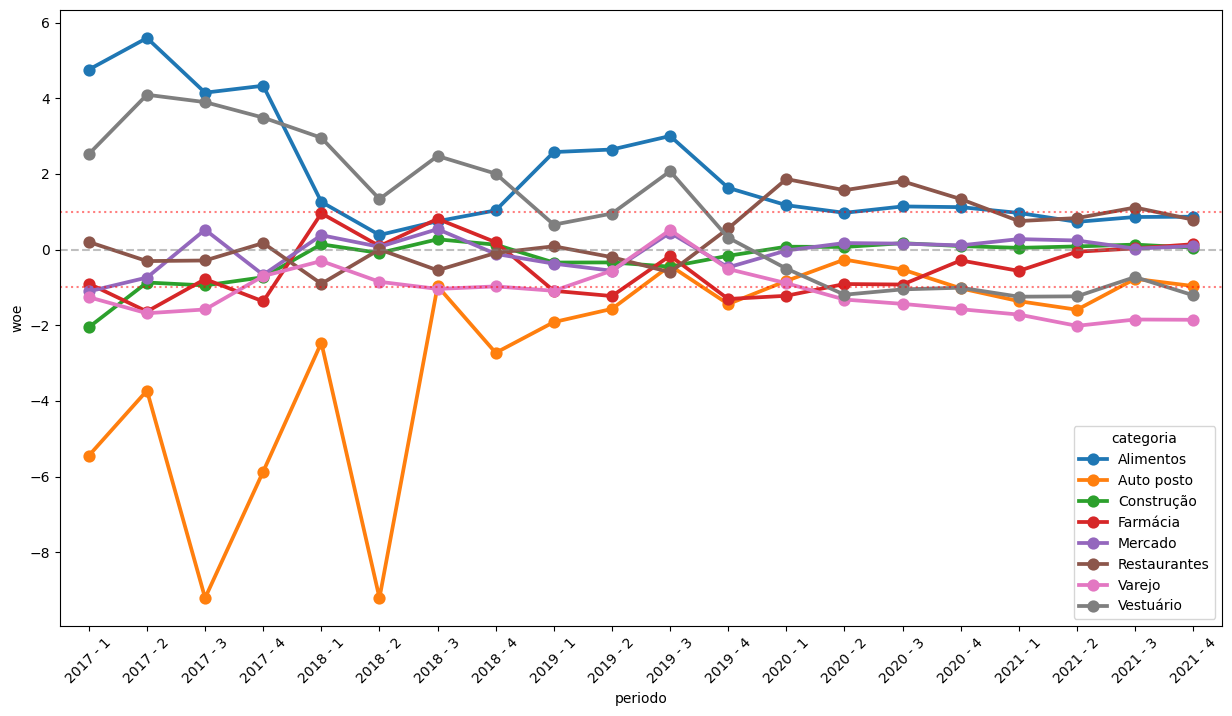

In [19]:
box_cat = sns.pointplot(data=df_cat, y = 'woe', x = 'periodo', hue='categoria', errorbar=None);
box_cat.tick_params(axis='x', labelrotation=45)

box_cat.axhline(1, linestyle=':'  , color='red', alpha=.5)
box_cat.axhline(0, linestyle='--' , color='grey', alpha=.5)
box_cat.axhline(-1, linestyle=':' , color='red', alpha=.5);

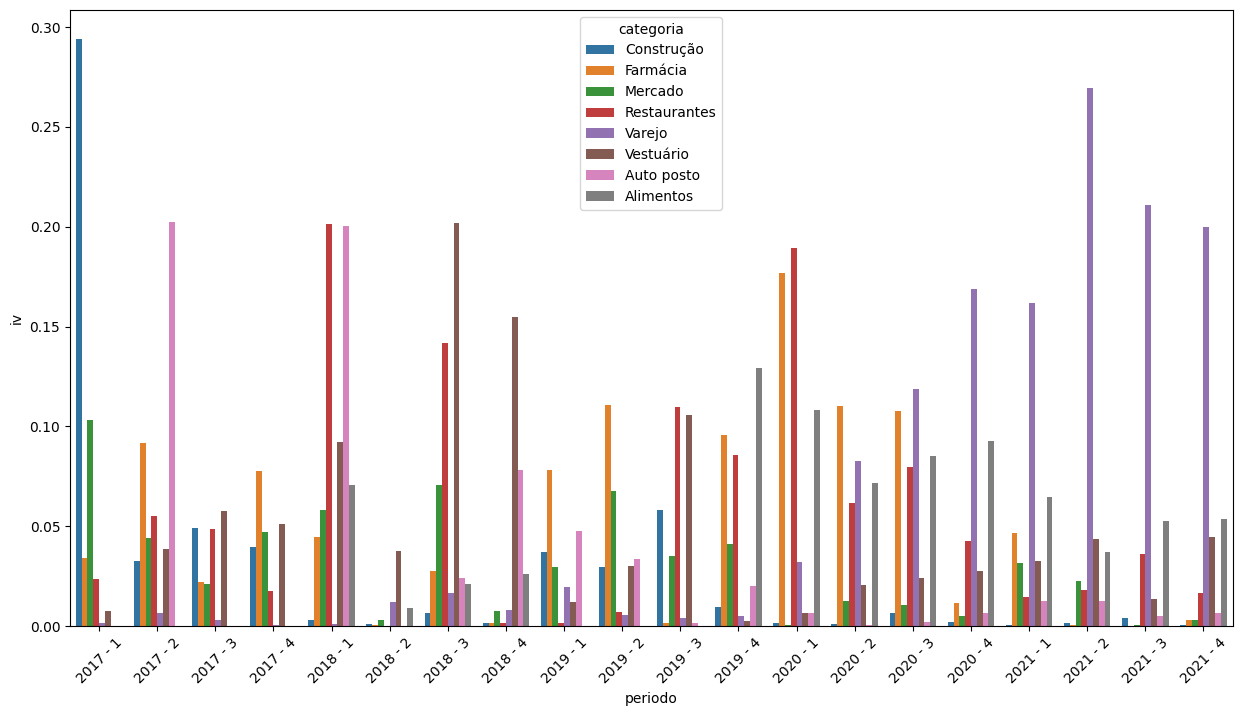

In [20]:
box_cat = sns.barplot(data=df_cat.query('iv < .5'), y = 'iv', x = 'periodo', hue='categoria', errorbar=None);
box_cat.tick_params(axis='x', labelrotation=45)

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

<div style="background-color: #eafce3; padding: 10px 5px 10px 5px;">

Ao longo da série histórica até o final de 2019, as categorias com maior proporção de notas com retorno eram **Alimentos** e **Vestuário**. 
    
<br>    
A partir do início de 2020, considerando o primeiro trimestre, Alimentos continua sendo uma categoria relevante, mas **Restaurantes** se tornam a categoria com maior relevância, enquanto **Vestuário** e **Vajero** passam a ser as menos relevantes.
    
<br>
    
Podemos verificar isso pelo gráfico de análise do WOE e também pelo IV. Provavelmente isso ocorreu pela pandemia de Covid19, forçando uma mudança no hábito das pessoas.
    
</div>